In [96]:
import time
import math
from typing import List

import numpy as np
from numpy import logical_and
import tensorflow as tf
import matplotlib.pyplot as plt

from Pyfhel import Pyfhel
from Pyfhel.PyPtxt import PyPtxt as PyfhelPlaintext
from Pyfhel.PyCtxt import PyCtxt as PyfhelCiphertext


In [97]:
mnist = tf.keras.datasets.mnist  ## data are downloaded ~/.keras/datasets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [98]:
print(f"{x_train.shape = }")
print(f"{y_train.shape = }")
print(f"{x_test.shape = }")
print(f"{y_test.shape = }")

x_train.shape = (60000, 28, 28)
y_train.shape = (60000,)
x_test.shape = (10000, 28, 28)
y_test.shape = (10000,)


## Quantizing the MNIST dataset into 2 bits

array([  0,   1,   2,   3,   9,  11,  14,  16,  18,  23,  24,  25,  26,
        27,  30,  35,  36,  39,  43,  45,  46,  49,  55,  56,  64,  66,
        70,  78,  80,  81,  82,  90,  93,  94, 107, 108, 114, 119, 126,
       127, 130, 132, 133, 135, 136, 139, 148, 150, 154, 156, 160, 166,
       170, 171, 172, 175, 182, 183, 186, 187, 190, 195, 198, 201, 205,
       207, 212, 213, 219, 221, 225, 226, 229, 238, 240, 241, 242, 244,
       247, 249, 250, 251, 252, 253, 255], dtype=uint8)

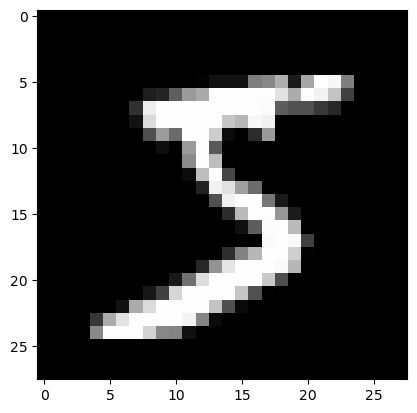

In [99]:
im = x_train[0]
plt.imshow(im, cmap='gray')
np.unique(im)

In [100]:
x_train = (x_train / 255.0 * 3).astype(int)
x_test = (x_test / 255.0 * 3).astype(int)

In [101]:
print(np.unique(x_train))
print(np.unique(x_test))

[0 1 2 3]
[0 1 2 3]


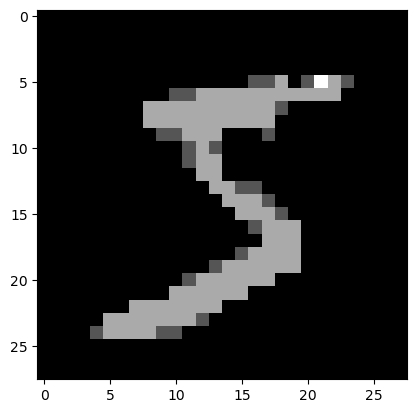

In [102]:
plt.imshow(x_train[0], cmap='gray')

In [103]:
x_test = np.expand_dims(x_test, axis=1)

In [104]:
x_test.shape

(10000, 1, 28, 28)

## Quantizing the weights (and biases) of the neural net

In [105]:
scale_factor_input = 1 / 3
bit_width = 4
cnn_py = __import__("quant_weights_16bits")

def quantise(element, s, b):
    upper = 2 ** (b - 1) - 1
    lower = -2 ** (b - 1)

    value = int(round(element / s))

    if value > upper:
        return upper
    elif value < lower:
        return lower
    else:
        return value

np_quantise = np.vectorize(quantise)

In [106]:
conv1_ind_scale = np.max(np.abs(cnn_py.conv2d)) / (2 ** (bit_width - 1) - 1)
conv1_scale = scale_factor_input * conv1_ind_scale
# conv1 activation (square)
conv1_scale_act = conv1_scale ** 2

# the 1/4 for the scaled average pooling
conv2_ind_scale = np.max(np.abs(cnn_py.conv2d_1)) / (2 ** (bit_width - 1) - 1)
conv2_scale = conv1_scale_act * conv2_ind_scale
# Activation
conv2_scale_act = conv2_scale ** 2

dense_ind_scale = np.max(np.abs(cnn_py.dense)) / (2 ** (bit_width - 1) - 1)
dense_scale = conv2_scale_act * dense_ind_scale

print(f"{conv1_ind_scale = }")
print(f"{conv1_scale = }")
print(f"{conv1_scale_act = }")
print(f"{conv2_ind_scale = }")
print(f"{conv2_scale = }")
print(f"{conv2_scale_act = }")
print(f"{dense_ind_scale = }")
print(f"{dense_scale = }")

conv1_ind_scale = 4681.0
conv1_scale = 1560.3333333333333
conv1_scale_act = 2434640.111111111
conv2_ind_scale = 4681.0
conv2_scale = 11396550360.11111
conv2_scale_act = 1.2988136011054868e+20
dense_ind_scale = 4681.0
dense_scale = 6.079746466774783e+23


In [107]:
# bias are just 0. Can just skip them, and we can quantize them to much bigger bit-width
conv1_bias = np_quantise(cnn_py.conv2d_bias, conv1_scale, 1024)
conv2_bias = np_quantise(cnn_py.conv2d_1_bias, conv2_scale, 1024)
dense_bias = np_quantise(cnn_py.dense_bias, dense_scale, 1024)

conv1_q = np_quantise(cnn_py.conv2d, conv1_ind_scale, bit_width)
conv2_q = np_quantise(cnn_py.conv2d_1, conv2_ind_scale, bit_width)
dense1_q = np_quantise(cnn_py.dense, dense_ind_scale, bit_width)

In [108]:
print(f"{np.unique(conv1_q) = }")
print(f"{np.unique(conv2_q) = }")
print(f"{np.unique(dense1_q) = }")

np.unique(conv1_q) = array([-6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7])
np.unique(conv2_q) = array([-7, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7])
np.unique(dense1_q) = array([-7, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6])


## Encrypted Computation

In [109]:
HE = Pyfhel()  # Creating empty Pyfhel object
# 16384; 8192
HE.contextGen(scheme='bfv', n=16384,
    t_bits=47)  # Plaintext modulus bit size
HE.keyGen()  # Key Generation: generates a pair of public/secret keys
HE.rotateKeyGen()  # Rotate key generation --> Allows rotation/shifting
HE.relinKeyGen()  # Relinearization key generation
HE.batchEnabled()
duplicate_factor = int((HE.get_nSlots() / 2) / 1024)

print(f"{HE.get_nSlots() = }")
print(f"{duplicate_factor = }")

HE.get_nSlots() = 16384
duplicate_factor = 8


In [110]:
def duplicate(vec, n):
    # repeating the vector `vec` the number of `n` times
    return np.tile(vec, n)

In [111]:
def rotation_conv(input_image, data_shape, input_shape, 
                  conv2d_kernel, bias, conv_stride, data_stride, fact, HE):

    original_shape = data_shape
    if len(original_shape) != 3:
        original_shape = (original_shape[0], int(np.sqrt(original_shape[1])), int(np.sqrt(original_shape[1])))

    kernel_shape = conv2d_kernel.shape
    output_shape = (int(np.floor((input_shape[1] - kernel_shape[2]-1) // conv_stride[0] + 1)),
                    int(np.floor((input_shape[2] - kernel_shape[3]-1) // conv_stride[1] + 1)))

    n = original_shape[1]
    n2 = n ** 2

    # input_flat = input_image.flatten()

    result = []

    if data_stride[0] == 1:
        for c_o in range(kernel_shape[0]):
            tmp = HE.encodeInt(np.zeros(4096, dtype=np.int64))
            for c_i in range(kernel_shape[1]):
                tmp_ency = input_image[c_i]
                for j in range(kernel_shape[2]):
                    for i in range(kernel_shape[3]):
                        # Extra check, else a transpartent Ctxt is created
                        if conv2d_kernel[c_o, c_i, j, i] != 0:
                            conv_kernel = HE.encodeInt(np.repeat(conv2d_kernel[c_o, c_i, j, i], 4096))
                            tmp_mult = tmp_ency << (i + n * j)
                            tmp_mult *= conv_kernel
                            tmp += tmp_mult
            # if c_o % 10 == 0:
            #     print("Kernel " + str(c_o))
            result.append(tmp)
    # TODO: Add extra statement for CiFAR
    elif data_stride[0] == 2:
        for c_o in range(kernel_shape[0]):
            tmp = HE.encodeInt(np.zeros(original_shape[1] * original_shape[2], dtype=np.int64))
            for c_i in range(kernel_shape[1]):
                tmp_ency = input_image[c_i]
                for j in range(kernel_shape[2]):
                    for i in range(kernel_shape[3]):
                        if conv2d_kernel[c_o, c_i, j, i] != 0:
                            conv_kernel = HE.encodeInt(np.repeat(conv2d_kernel[c_o, c_i, j, i], 4096))
                            tmp_mult = tmp_ency << ((i * 2) + n * (j * 2))
                            tmp_mult *= conv_kernel
                            tmp += tmp_mult

            result.append(tmp)

    # Need to be placed here, now the mask will turn everything that need to be zero to zero
    for i in range(kernel_shape[0]):
        result[i] += HE.encode(bias[i])

    # Dimension of the output C_O, C_I, W, H
    mask = np.ones((kernel_shape[0], 1, output_shape[0], output_shape[1]), dtype=np.int64)

    # ToDo: Now only works for max conv_stride = 2
    # Diliation type of spread out
    if conv_stride[0] > 1:
        # When stride of a convolution is >1, the data is split out with a factor of data_stride
        zeros = 2 ** data_stride[0]
        for i in range(output_shape[1] - 1):
            for j in range(zeros - 1):
                mask = np.insert(mask, zeros * i + j + 1, 0, axis=3)
        for i in range(output_shape[1] - 1):
            for j in range(zeros - 1):
                mask = np.insert(mask, zeros * i + j + 1, 0, axis=2)

    mask = np.pad(mask, ((0, 0),
                         (0, 0),
                         (0, original_shape[1] - mask.shape[2]),
                         (0, original_shape[2] - mask.shape[3])))

    mask = np.append(mask[0, :].flatten(), np.zeros(240, dtype=np.int64))
    mask = HE.encodeInt(duplicate(mask, fact))

    for i in range(len(result)):
        result[i] *= mask

    # result = result * HE.encodeInt(mask.reshape(kernel_shape[0], original_shape[1] * original_shape[2]).flatten())
    return result


def expand_mat(mat, mat_shape, data_shape, data_stride):
    if data_stride[0] > 1:
        zeros = 2 ** (data_stride[0] - 1)

        for j in range(data_shape[2]):
            for i in range(data_shape[1]):
                for k in range(zeros - 1):
                    mat = np.insert(mat, zeros * mat_shape[1] * j + zeros * i + k + 1, 0, axis=1)

            for i in range(zeros * mat_shape[1] - zeros * data_shape[1]):
                mat = np.insert(mat, zeros * mat_shape[1] * j + zeros * data_shape[1] + i, 0, axis=1)

        diff = mat_shape[1] * mat_shape[1] - mat.shape[1]

        mat = np.append(mat, np.zeros((mat.shape[0], diff), dtype=np.int64), axis=1)

    else:
        diff = mat_shape[1] - data_shape[1]

        for i in range(data_shape[1]):
            for j in range(diff):
                # Always want to have 20 data point, followed by 8 zeros, and then back again 20 data points
                mat = np.insert(mat, data_shape[1] * (i + 1) + i * diff + j, 0, axis=1)

        mat = np.append(mat, np.zeros((mat.shape[0], diff * mat_shape[1]), dtype=np.int64), axis=1)
    return mat


def rot_plain(a, b, n_o, n_i, fact, HE):
    div_oi = int(n_i / n_o)
    slot_size = fact * n_i

    diag = np.zeros((n_o, n_i), dtype=np.int64)

    for j in range(n_o):
        tmp = get_diagonal(j, a)
        if div_oi > 1:
            for i in range(div_oi - 1):
                tmp = np.append(tmp, get_diagonal(j + (i + 1) * n_o, a))

        diag[j] = tmp

    output = HE.encodeInt(np.zeros(slot_size, dtype=np.int64))
    pad_length = 240 + 7*1024

    counter = 0
    for i in range(n_o):
        if np.sum(np.abs(diag[i])) != 0:
            output += HE.encodeInt(duplicate(diag[i], fact)) * (b << i)
            counter += 1
        # output += diag[i] * np.roll(b, -i)
        # output += np.tile(diag[i], fact) * np.roll(b, -i)

    result = HE.encodeInt(np.zeros(slot_size, dtype=np.int64))
    if counter != 0:
        for i in range(div_oi):
            result += (output << (8192 - (i * n_o + pad_length)))
        return result
    else:
        return None
    
def get_diagonal(pos, mat):
    max_size = max(mat.shape[0], mat.shape[1])
    min_size = min(mat.shape[0], mat.shape[1])

    diag = np.zeros(min_size, dtype=np.int64)
    j = pos
    i = 0
    k = 0

    while (i < max_size - pos) and (i < min_size) and (j < max_size):
        diag[k] = mat[i, j]
        k += 1
        i += 1
        j += 1

    i = max_size - pos
    j = 0

    while (i < mat.shape[0]) and (j < pos):
        diag[k] = mat[i, j]
        k += 1
        i += 1
        j += 1

    return diag

In [112]:
nb_tests = 1  # number of test images
acc, acc_he = 0, 0

for i in range(nb_tests):
    # Pad the flattened input image to have length 1024. Then duplicate it
    # `duplicate_factor` times due to batching properties of FHE
    input_image: np.ndarray = duplicate(
        vec=np.append(x_test[i].flatten(), np.zeros(240, dtype=np.int64)), 
        n=duplicate_factor
    )

    input_image: PyfhelPlaintext = HE.encodeInt(input_image)
    input_image: List[PyfhelCiphertext] = [HE.encrypt(input_image)]

    start_time_one = time.time()

    # first encrypted conv layer (enc input, plaintext weights)
    conv1_rot: List[PyfhelCiphertext] = rotation_conv(
        input_image=input_image, data_shape=(1, 28, 28), input_shape=(1, 28, 28),
        conv2d_kernel=conv1_q, bias=conv1_bias, conv_stride=cnn_py.conv2d_stride, 
        data_stride=(1, 1), fact=duplicate_factor, HE=HE
    )

    # first square activation
    conv1_act_rot: List[PyfhelCiphertext] = []
    for j in range(len(conv1_rot)):
        # result.append(HE.decryptInt(conv1_rot[j]))
        conv1_act_rot.append((HE.power(conv1_rot[j], 2)))
    
    # second encrypted conv layer 
    conv2_rot: List[PyfhelCiphertext] = rotation_conv(
        input_image=conv1_act_rot, data_shape=(1, 28, 28), input_shape=(5, 12, 12), 
        conv2d_kernel=conv2_q, bias=conv2_bias, conv_stride=cnn_py.conv2d_1_stride, 
        data_stride=(2, 2), fact=duplicate_factor, HE=HE
    )

    # second square activation
    conv2_act_rot: List[PyfhelCiphertext] = []
    for j in range(len(conv2_rot)):
        # result.append(HE.decryptInt(conv2_rot[j]))
        conv2_act_rot.append(HE.power(conv2_rot[j], 2))

    # the dense layer
    dense = []
    slide_size = int(cnn_py.dense_input / cnn_py.conv2d_1_out_channels)

    for j in range(50):
        w_tmp = expand_mat(
            mat=dense1_q[:, j * slide_size:(j + 1) * slide_size], 
            mat_shape=(1, 28, 28), data_shape=(1, 4, 4),
            data_stride=(3, 3)
        )
        w_tmp = np.append(w_tmp, np.zeros((10, 240)), axis=1)
        w_tmp = np.append(w_tmp, np.zeros((6, 1024)), axis=0)
        rot_out = rot_plain(
            a=w_tmp, b=conv2_act_rot[j], 
            n_o=16, n_i=1024, 
            fact=duplicate_factor, HE=HE)
        if rot_out != None:
            dense.append(rot_out)

    dense_dec = np.zeros(10, dtype=np.int64)
    for k in range(len(dense)):
        # print(HE.noise_level(dense[k]))
        decrypt = HE.decryptInt(dense[k])
        dense_dec += decrypt[:10]

    dense_dec += dense_bias
    if np.argmax(dense_dec[:10]) == y_test[i]:
        acc_he += 1

    if i % 1 == 0:
        single_time = time.time() - start_time_one
        print("Single time " + str(single_time))
        print(str(i) + "\t" + str(acc) + "\t" + str(acc_he) + "\t" + str(HE.noise_level(dense[0])))

Single time 622.5205037593842
0	0	0	0
